<a href="https://colab.research.google.com/github/prishu-b/breastCancerDetection/blob/main/CATGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [ ]:
from google.colab import drive
!touch drive.mount('/content/drive/MyDrive/catsImages')

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `touch drive.mount('/content/drive/MyDrive/catsImages')'


In [ ]:
DATA_DIR = "/content/drive/MyDrive/catsImages"

In [ ]:
print(os.listdir(DATA_DIR))


['cats']


In [ ]:
print(os.listdir(DATA_DIR+"")[:10])


['cats']


In [ ]:
image_size = 64
batch_size = 128

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


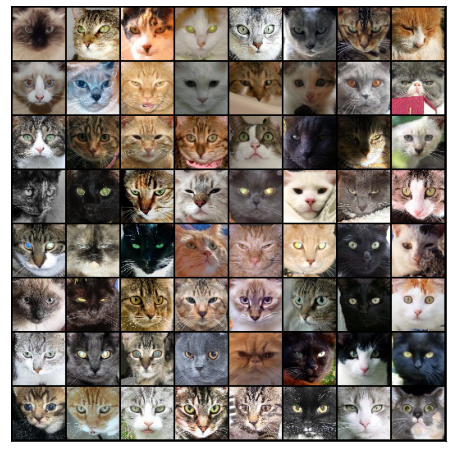

In [ ]:
show_batch(train_dl)


In [ ]:
latent_size = 128


In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)


In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device) #changed latent size
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device) #changed latent size
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
history = fit(100, 0.0002)


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/100], loss_g: 4.3592, loss_d: 1.0502, real_score: 0.6616, fake_score: 0.4295
Saving generated-images-0001.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 6.4334, loss_d: 0.5759, real_score: 0.7946, fake_score: 0.2377
Saving generated-images-0002.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 6.4822, loss_d: 0.2962, real_score: 0.8198, fake_score: 0.0347
Saving generated-images-0003.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 8.7593, loss_d: 0.3470, real_score: 0.8896, fake_score: 0.1816
Saving generated-images-0004.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 13.1326, loss_d: 1.2255, real_score: 0.9413, fake_score: 0.6542
Saving generated-images-0005.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 9.5460, loss_d: 0.0695, real_score: 0.9405, fake_score: 0.0035
Saving generated-images-0006.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 8.9701, loss_d: 0.1277, real_score: 0.9044, fake_score: 0.0002
Saving generated-images-0007.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 11.6732, loss_d: 0.1404, real_score: 0.8810, fake_score: 0.0000
Saving generated-images-0008.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 12.8548, loss_d: 0.3416, real_score: 0.7590, fake_score: 0.0000
Saving generated-images-0009.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 10.7017, loss_d: 0.2101, real_score: 0.8335, fake_score: 0.0001
Saving generated-images-0010.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 7.0723, loss_d: 0.2426, real_score: 0.8917, fake_score: 0.1001
Saving generated-images-0011.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 13.8107, loss_d: 1.7923, real_score: 0.9609, fake_score: 0.7716
Saving generated-images-0012.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 5.7256, loss_d: 0.2619, real_score: 0.9627, fake_score: 0.1811
Saving generated-images-0013.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 6.8964, loss_d: 0.4709, real_score: 0.6840, fake_score: 0.0081
Saving generated-images-0014.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 7.7444, loss_d: 0.1000, real_score: 0.9181, fake_score: 0.0033
Saving generated-images-0015.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 6.4334, loss_d: 0.1835, real_score: 0.9388, fake_score: 0.1080
Saving generated-images-0016.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 9.9272, loss_d: 0.3022, real_score: 0.9260, fake_score: 0.1793
Saving generated-images-0017.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 6.8605, loss_d: 0.1318, real_score: 0.8909, fake_score: 0.0051
Saving generated-images-0018.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 5.6664, loss_d: 0.0878, real_score: 0.9250, fake_score: 0.0065
Saving generated-images-0019.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 6.3664, loss_d: 0.1362, real_score: 0.9199, fake_score: 0.0448
Saving generated-images-0020.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 7.2323, loss_d: 0.1236, real_score: 0.9448, fake_score: 0.0573
Saving generated-images-0021.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 6.5196, loss_d: 0.0816, real_score: 0.9782, fake_score: 0.0566
Saving generated-images-0022.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 6.1843, loss_d: 0.0876, real_score: 0.9501, fake_score: 0.0341
Saving generated-images-0023.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 6.0586, loss_d: 0.1222, real_score: 0.9333, fake_score: 0.0475
Saving generated-images-0024.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 6.8636, loss_d: 0.0898, real_score: 0.9676, fake_score: 0.0543
Saving generated-images-0025.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 7.1807, loss_d: 0.0643, real_score: 0.9739, fake_score: 0.0365
Saving generated-images-0026.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 7.0916, loss_d: 0.0475, real_score: 0.9788, fake_score: 0.0253
Saving generated-images-0027.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 6.6273, loss_d: 0.0287, real_score: 0.9770, fake_score: 0.0050
Saving generated-images-0028.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 5.5413, loss_d: 8.9287, real_score: 0.0010, fake_score: 0.0000
Saving generated-images-0029.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 4.1472, loss_d: 0.2813, real_score: 0.8054, fake_score: 0.0221
Saving generated-images-0030.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 3.7214, loss_d: 0.2607, real_score: 0.8930, fake_score: 0.1245
Saving generated-images-0031.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 4.6380, loss_d: 0.2389, real_score: 0.9077, fake_score: 0.1195
Saving generated-images-0032.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 5.0393, loss_d: 0.2946, real_score: 0.8886, fake_score: 0.1513
Saving generated-images-0033.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 4.4942, loss_d: 0.3603, real_score: 0.7526, fake_score: 0.0351
Saving generated-images-0034.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 5.4741, loss_d: 0.2791, real_score: 0.8916, fake_score: 0.1422
Saving generated-images-0035.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 4.9966, loss_d: 0.4276, real_score: 0.8545, fake_score: 0.1200
Saving generated-images-0036.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 3.3355, loss_d: 0.3984, real_score: 0.8966, fake_score: 0.1703
Saving generated-images-0037.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 4.2078, loss_d: 0.4247, real_score: 0.7132, fake_score: 0.0179
Saving generated-images-0038.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 3.8698, loss_d: 0.8838, real_score: 0.5419, fake_score: 0.0167
Saving generated-images-0039.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 6.7379, loss_d: 0.8221, real_score: 0.9473, fake_score: 0.4807
Saving generated-images-0040.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 3.4899, loss_d: 0.1967, real_score: 0.8502, fake_score: 0.0234
Saving generated-images-0041.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 3.9091, loss_d: 0.2591, real_score: 0.8803, fake_score: 0.1052
Saving generated-images-0042.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 1.4018, loss_d: 2.0571, real_score: 0.1830, fake_score: 0.0529
Saving generated-images-0043.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 2.0465, loss_d: 0.5145, real_score: 0.7720, fake_score: 0.2121
Saving generated-images-0044.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 3.3142, loss_d: 0.3469, real_score: 0.8982, fake_score: 0.2036
Saving generated-images-0045.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 2.9848, loss_d: 0.5038, real_score: 0.7470, fake_score: 0.1611
Saving generated-images-0046.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 3.7049, loss_d: 0.3467, real_score: 0.8267, fake_score: 0.1190
Saving generated-images-0047.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 4.7762, loss_d: 0.3577, real_score: 0.9211, fake_score: 0.2146
Saving generated-images-0048.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 6.2765, loss_d: 0.4138, real_score: 0.9480, fake_score: 0.2799
Saving generated-images-0049.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 6.1956, loss_d: 0.3974, real_score: 0.9338, fake_score: 0.2631
Saving generated-images-0050.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 6.8713, loss_d: 0.4126, real_score: 0.9117, fake_score: 0.2480
Saving generated-images-0051.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 5.9704, loss_d: 0.3246, real_score: 0.8943, fake_score: 0.1691
Saving generated-images-0052.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 5.3175, loss_d: 1.2805, real_score: 0.5454, fake_score: 0.0372
Saving generated-images-0053.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 6.9783, loss_d: 0.3785, real_score: 0.9204, fake_score: 0.2291
Saving generated-images-0054.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 3.4521, loss_d: 0.1594, real_score: 0.9029, fake_score: 0.0402
Saving generated-images-0055.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 8.5653, loss_d: 0.6959, real_score: 0.9815, fake_score: 0.4295
Saving generated-images-0056.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 2.7529, loss_d: 0.1234, real_score: 0.9161, fake_score: 0.0305
Saving generated-images-0057.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 4.4494, loss_d: 0.2652, real_score: 0.9429, fake_score: 0.1666
Saving generated-images-0058.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 3.6673, loss_d: 0.3490, real_score: 0.8527, fake_score: 0.1450
Saving generated-images-0059.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 2.4497, loss_d: 0.4849, real_score: 0.7364, fake_score: 0.0515
Saving generated-images-0060.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 4.6701, loss_d: 0.5014, real_score: 0.9350, fake_score: 0.3361
Saving generated-images-0061.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 5.2320, loss_d: 0.4682, real_score: 0.9551, fake_score: 0.3041
Saving generated-images-0062.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 9.8644, loss_d: 1.7730, real_score: 0.9953, fake_score: 0.7894
Saving generated-images-0063.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 4.5638, loss_d: 0.2641, real_score: 0.8775, fake_score: 0.0970
Saving generated-images-0064.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 6.8105, loss_d: 0.6604, real_score: 0.9138, fake_score: 0.3906
Saving generated-images-0065.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 5.1763, loss_d: 0.6285, real_score: 0.8960, fake_score: 0.3490
Saving generated-images-0066.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 4.1322, loss_d: 0.4554, real_score: 0.8161, fake_score: 0.1630
Saving generated-images-0067.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 5.0410, loss_d: 0.3309, real_score: 0.9037, fake_score: 0.1853
Saving generated-images-0068.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 4.1020, loss_d: 0.3166, real_score: 0.8549, fake_score: 0.1036
Saving generated-images-0069.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 5.1056, loss_d: 0.1223, real_score: 0.9031, fake_score: 0.0047
Saving generated-images-0070.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 6.5345, loss_d: 0.6821, real_score: 0.9640, fake_score: 0.4170
Saving generated-images-0071.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 7.1730, loss_d: 0.6032, real_score: 0.8996, fake_score: 0.3407
Saving generated-images-0072.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 4.8987, loss_d: 0.7242, real_score: 0.9436, fake_score: 0.4434
Saving generated-images-0073.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 4.5913, loss_d: 0.4846, real_score: 0.9205, fake_score: 0.2860
Saving generated-images-0074.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 3.2449, loss_d: 0.3646, real_score: 0.8049, fake_score: 0.0913
Saving generated-images-0075.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 1.3788, loss_d: 0.9267, real_score: 0.5050, fake_score: 0.0312
Saving generated-images-0076.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 4.4890, loss_d: 0.4227, real_score: 0.8017, fake_score: 0.1233
Saving generated-images-0077.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 3.8802, loss_d: 0.7427, real_score: 0.5613, fake_score: 0.0296
Saving generated-images-0078.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 2.7341, loss_d: 0.5586, real_score: 0.7049, fake_score: 0.1046
Saving generated-images-0079.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 3.0266, loss_d: 0.5032, real_score: 0.7117, fake_score: 0.0776
Saving generated-images-0080.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 4.0060, loss_d: 0.2774, real_score: 0.8265, fake_score: 0.0526
Saving generated-images-0081.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 4.2565, loss_d: 0.4236, real_score: 0.8463, fake_score: 0.1900
Saving generated-images-0082.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 6.2578, loss_d: 0.3625, real_score: 0.9563, fake_score: 0.2437
Saving generated-images-0083.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 2.6984, loss_d: 1.0512, real_score: 0.4857, fake_score: 0.0194
Saving generated-images-0084.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 3.5742, loss_d: 0.3630, real_score: 0.7916, fake_score: 0.0767
Saving generated-images-0085.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 4.1141, loss_d: 0.3977, real_score: 0.8112, fake_score: 0.1111
Saving generated-images-0086.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 2.7716, loss_d: 0.2146, real_score: 0.9148, fake_score: 0.0679
Saving generated-images-0087.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 4.3916, loss_d: 0.4301, real_score: 0.9532, fake_score: 0.2840
Saving generated-images-0088.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 5.0386, loss_d: 0.5786, real_score: 0.8142, fake_score: 0.2742
Saving generated-images-0089.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 5.0912, loss_d: 0.3725, real_score: 0.8624, fake_score: 0.1655
Saving generated-images-0090.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 6.6178, loss_d: 0.4436, real_score: 0.9067, fake_score: 0.2584
Saving generated-images-0091.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 2.6868, loss_d: 0.3762, real_score: 0.9875, fake_score: 0.2467
Saving generated-images-0092.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 3.6875, loss_d: 0.4364, real_score: 0.8968, fake_score: 0.2483
Saving generated-images-0093.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 4.3646, loss_d: 0.4429, real_score: 0.8869, fake_score: 0.2522
Saving generated-images-0094.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 4.7573, loss_d: 0.8510, real_score: 0.5481, fake_score: 0.0113
Saving generated-images-0095.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 4.5723, loss_d: 0.4527, real_score: 0.8398, fake_score: 0.1769
Saving generated-images-0096.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 3.6090, loss_d: 0.4197, real_score: 0.7524, fake_score: 0.0577
Saving generated-images-0097.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 2.1814, loss_d: 0.5504, real_score: 0.6653, fake_score: 0.0488
Saving generated-images-0098.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 3.9130, loss_d: 1.0208, real_score: 0.6062, fake_score: 0.0810
Saving generated-images-0099.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 4.3175, loss_d: 0.4918, real_score: 0.8302, fake_score: 0.2117
Saving generated-images-0100.png


In [ ]:
from IPython.display import Image


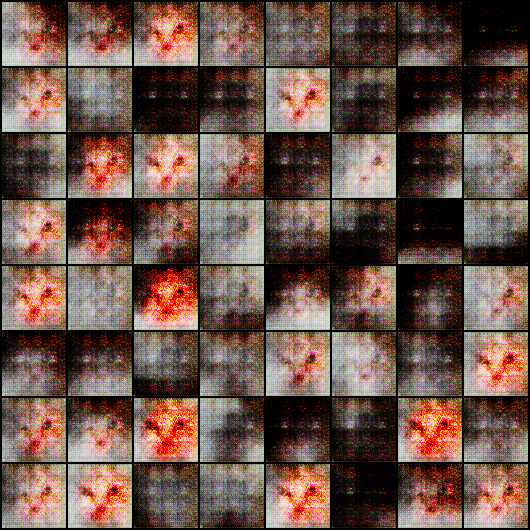

In [ ]:
Image('./generated/generated-images-0060.png')
